In [1]:
# Basic imports
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Paths
THIS_DIR   = Path.cwd()          # assume we're inside visualization/
ROOT_DIR   = THIS_DIR.parent
RESULTS_DIR = ROOT_DIR / "results"

FIG_DIR = THIS_DIR / "figures" / "best_unet"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# Load Best-UNet CSV
# --------------------------------------------------
CSV = RESULTS_DIR / "best_unet" / "metrics.csv"
if not CSV.exists():
    raise FileNotFoundError(CSV)
df = pd.read_csv(CSV)

# Separate numeric epochs (row 0-19) from the "test" row
numeric_mask = pd.to_numeric(df["epoch"], errors="coerce").notna()
train_df = df[numeric_mask].copy()          # rows 0-19
test_row = df[~numeric_mask]                # optional
print("Loaded Best-UNet metrics:", CSV.relative_to(ROOT_DIR))


Loaded Best-UNet metrics: results/best_unet/metrics.csv


Saved → visualization/figures/best_unet/loss_train_vs_val.png


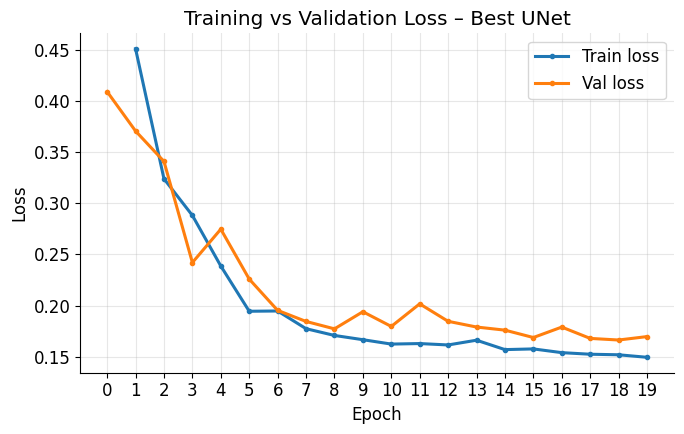

In [2]:
mpl.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.3,
    "font.size": 12, "lines.linewidth": 2.2,
})

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(train_df["epoch"], train_df["train/loss_epoch"],
        label="Train loss", marker="o", ms=3)
ax.plot(train_df["epoch"], train_df["val/loss"],
        label="Val loss",   marker="o", ms=3)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training vs Validation Loss – Best UNet")
ax.legend()
fig.tight_layout()

p = FIG_DIR / "loss_train_vs_val.png"
fig.savefig(p, dpi=300); print("Saved →", p.relative_to(ROOT_DIR))
plt.show()


/tmp/ipykernel_76052/1399533232.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved → visualization/figures/best_unet/rmse_vs_epoch.png


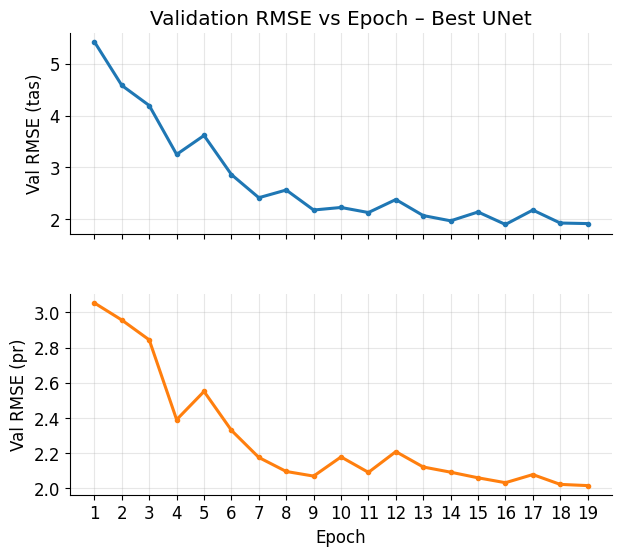

In [3]:
fig, (ax_tas, ax_pr) = plt.subplots(2, 1, figsize=(7, 6),
                                    sharex=True, gridspec_kw={"hspace": 0.3})
ax_tas.plot(train_df["epoch"], train_df["val/tas/rmse"],
            color="tab:blue", marker="o", ms=3)
ax_pr .plot(train_df["epoch"], train_df["val/pr/rmse"],
            color="tab:orange", marker="o", ms=3)

ax_tas.set_ylabel("Val RMSE (tas)")
ax_tas.set_title("Validation RMSE vs Epoch – Best UNet")

ax_pr.set_ylabel("Val RMSE (pr)")
ax_pr.set_xlabel("Epoch")
fig.tight_layout()

p = FIG_DIR / "rmse_vs_epoch.png"
fig.savefig(p, dpi=300); print("Saved →", p.relative_to(ROOT_DIR))
plt.show()


/tmp/ipykernel_76052/1824245570.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved → visualization/figures/best_unet/time_mean_std_progression.png


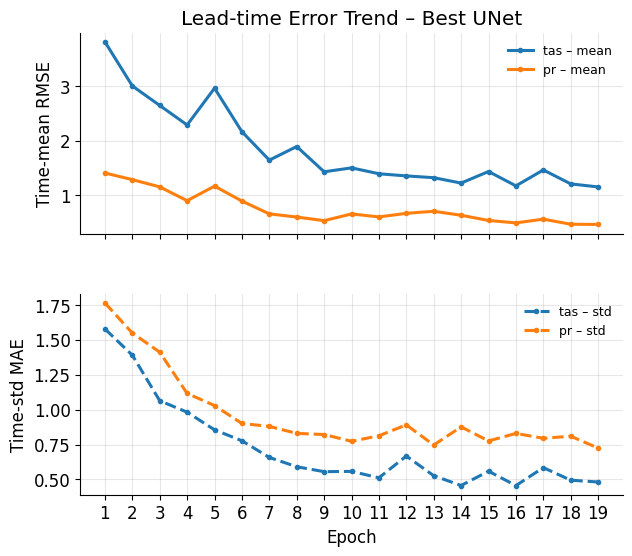

In [4]:
fig, (ax_mean, ax_std) = plt.subplots(2, 1, figsize=(7, 6),
                                      sharex=True, gridspec_kw={"hspace": 0.3})

# —— time-mean —— 
ax_mean.plot(train_df["epoch"], train_df["val/tas/time_mean_rmse"],
             color="tab:blue",  marker="o", ms=3, label="tas – mean")
ax_mean.plot(train_df["epoch"], train_df["val/pr/time_mean_rmse"],
             color="tab:orange", marker="o", ms=3, label="pr – mean")
ax_mean.set_ylabel("Time-mean RMSE")
ax_mean.set_title("Lead-time Error Trend – Best UNet")
ax_mean.legend(frameon=False, fontsize=9)

# —— time-STD —— 
ax_std.plot(train_df["epoch"], train_df["val/tas/time_std_mae"],
            color="tab:blue",  marker="o", ms=3, linestyle="--",
            label="tas – std")
ax_std.plot(train_df["epoch"], train_df["val/pr/time_std_mae"],
            color="tab:orange", marker="o", ms=3, linestyle="--",
            label="pr – std")
ax_std.set_ylabel("Time-std MAE")
ax_std.set_xlabel("Epoch")
ax_std.legend(frameon=False, fontsize=9)

fig.tight_layout()
p = FIG_DIR / "time_mean_std_progression.png"
fig.savefig(p, dpi=300); print("Saved →", p.relative_to(ROOT_DIR))
plt.show()


Saved → visualization/figures/best_unet/trajectory_tas_vs_pr.png


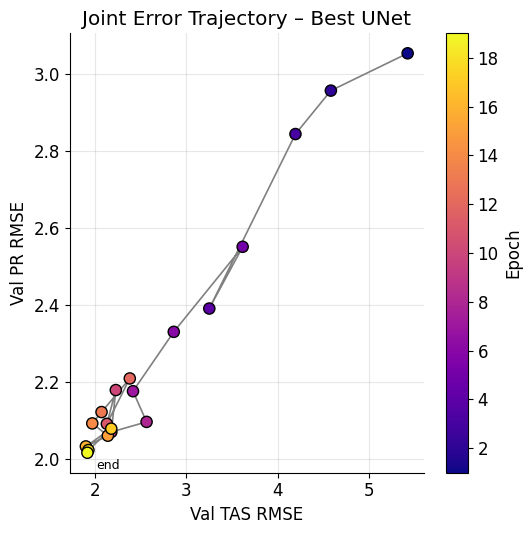

In [7]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 5  —  Fancy 2-D trajectory  (dtype-safe)
# ────────────────────────────────────────────────────────────────────────────────
import numpy as np
from matplotlib.cm import plasma

fig, ax = plt.subplots(figsize=(5.5, 5.5))

# Ensure epochs are numeric for the colour-map
epoch_numeric = pd.to_numeric(train_df["epoch"], errors="coerce")

# Scatter with colour = epoch
sc = ax.scatter(train_df["val/tas/rmse"],
                train_df["val/pr/rmse"],
                c=epoch_numeric,
                cmap="plasma",
                s=65,           # slightly larger points
                edgecolor="k",
                zorder=3)

# Thin grey line connecting points
ax.plot(train_df["val/tas/rmse"],
        train_df["val/pr/rmse"],
        color="grey", linewidth=1.2, zorder=2)

ax.set_xlabel("Val TAS RMSE")
ax.set_ylabel("Val PR RMSE")
ax.set_title("Joint Error Trajectory – Best UNet")

# Colour-bar showing epoch progression
cbar = fig.colorbar(sc, ax=ax, label="Epoch")

# Annotate start / end
ax.annotate("start",
            xy=(train_df["val/tas/rmse"].iloc[0],
                train_df["val/pr/rmse"].iloc[0]),
            xytext=(6, 6),
            textcoords="offset points",
            fontsize=9)
ax.annotate("end",
            xy=(train_df["val/tas/rmse"].iloc[-1],
                train_df["val/pr/rmse"].iloc[-1]),
            xytext=(6, -12),
            textcoords="offset points",
            fontsize=9)

fig.tight_layout()
p = FIG_DIR / "trajectory_tas_vs_pr.png"
fig.savefig(p, dpi=300)
print("Saved →", p.relative_to(ROOT_DIR))
plt.show()


In [6]:
print("Saved figures:")
for p in sorted(FIG_DIR.glob("*.png")):
    print(" •", p.relative_to(ROOT_DIR))


Saved figures:
 • visualization/figures/best_unet/loss_train_vs_val.png
 • visualization/figures/best_unet/rmse_vs_epoch.png
 • visualization/figures/best_unet/time_mean_std_progression.png
